C:\Users\germa\AppData\Local\Temp\ipykernel_25336\3462579534.py:117: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Cholesterol'].replace(0, chol_median, inplace=True)
C:\Users\germa\AppData\Local\Temp\ipykernel_25336\3462579534.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
{'ccp_alpha': 0.005, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}


c:\Users\germa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy with AdaBoost 0.8837209302325582
Accuracy with RandomForest 0.8449612403100775
Accuracy with LogisticRegression 0.8449612403100775
'numpy.ndarray' object has no attribute 'compare'
'numpy.ndarray' object has no attribute 'compare'
'numpy.ndarray' object has no attribute 'compare'
0.8604651162790697


c:\Users\germa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Voting Classifier Accuracy: 0.8604651162790697


C:\Users\germa\AppData\Local\Temp\ipykernel_25336\3462579534.py:243: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Cholesterol'].replace(0, chol_median, inplace=True)
C:\Users\germa\AppData\Local\Temp\ipykernel_25336\3462579534.py:246: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

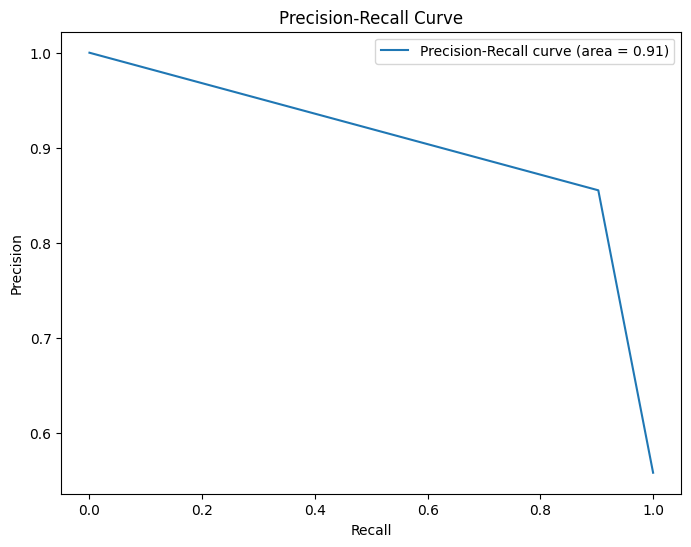

F1-Score: 0.85981
Precision: 0.86086
Recall: 0.86047
Accuracy: 0.86047


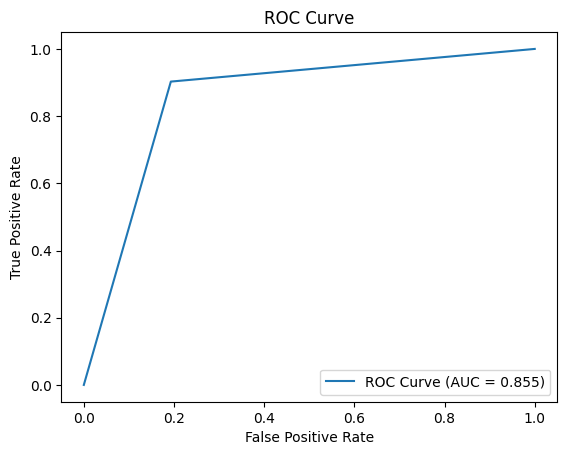

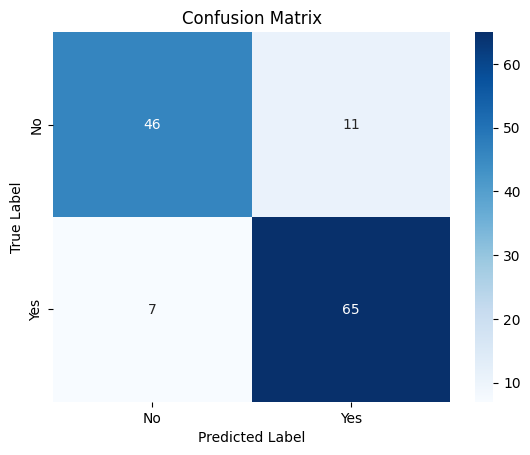

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import category_encoders as ce
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRFClassifier

import sweetviz as sv
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, accuracy_score,
                             roc_auc_score, roc_curve)
from sklearn.metrics import precision_recall_curve, auc


# PLOTTING FUNCTIONS
def plot_precision_recall_curve(y_true, y_scores):
    """
    Plot Precision-Recall curve for the model.
    
    Parameters:
    - y_true: Actual target values.
    - y_scores: Target scores, can either be probability estimates of the positive class.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_score = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()




def performance_metrics(y_true, y_pred):
    """Calculate and print model performance metrics."""
    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Print metrics
    print(f'F1-Score: {f1:.5f}\nPrecision: {precision:.5f}\nRecall: {recall:.5f}\nAccuracy: {accuracy:.5f}')


def roc_curve_plot(y_true, y_probs):
    """Plot ROC curve based on true labels and predicted probabilities."""
    roc_auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')
    plt.savefig('roc_curve.png')
    plt.show()

def confusion_matrix_heatmap(y_true, y_pred):
    """Generate and display a confusion matrix heatmap."""
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix_heatmap.png')
    plt.show()


def plot_feature_importance(model, feature_names, top_n_features=20):
    """
    Plot the importance of features in the model.
    
    Parameters:
    - model: The trained model.
    - feature_names: List of names corresponding to the features used by the model.
    """
    # Extract feature importance from the model
    importances = model.feature_importances_
    
    # Sort feature importances in descending order and select the top N
    indices = np.argsort(importances)[::-1][:top_n_features]
    
    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]
    
    # Create plot
    plt.figure(figsize=(10, 5))
    plt.title("Top {} Feature Importance".format(top_n_features))
    plt.bar(range(top_n_features), sorted_importances, align='center')
    
    # Add feature names as x-axis labels
    plt.xticks(range(top_n_features), names, rotation=45, ha='right')
    
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()



# Load the data
train_data = pd.read_csv('train_heart.csv', sep=',')
test_data = pd.read_csv('test_heart.csv', sep=',')

# Filter values for Cholesterol and RestingBP
chol_median = train_data.loc[train_data['Cholesterol'] != 0, 'Cholesterol'].median()
train_data['Cholesterol'].replace(0, chol_median, inplace=True)

resting_median = train_data.loc[train_data['RestingBP'] != 0, 'RestingBP'].median()
train_data['RestingBP'].replace(0, resting_median, inplace=True)

# Create interaction term
train_data['Age_Chol_Interact'] = train_data['Age'] * train_data['Cholesterol']

# Encode categorical variables
categorical_columns = train_data.select_dtypes(include=['object']).columns
encoder = ce.OrdinalEncoder(cols=categorical_columns)
X_encoded = encoder.fit_transform(train_data.drop(['id', 'HeartDisease'], axis=1))

#poly features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_encoded = poly.fit_transform(X_encoded)
poly_feature_names = poly.get_feature_names_out(input_features=encoder.get_feature_names_out())

scaler = StandardScaler()
X_encoded = scaler.fit_transform(X_encoded)

# Split the data into training and test sets
y = train_data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning with GridSearchCV
param_grid_ada = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05, 0.1],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

grid_search_ada = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_ada,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_ada.fit(X_train, y_train)

best_params_ada = grid_search_ada.best_params_
best_est_ada = grid_search_ada.best_estimator_

print(best_params_ada)

dict_weights = {1:1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1}

# Model Training with AdaBoost
ada_boost_clf = AdaBoostClassifier(estimator=best_est_ada, n_estimators=1000, random_state=42)
ada_boost_clf.fit(X_train, y_train)
y_pred_ada = ada_boost_clf.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print('Accuracy with AdaBoost', accuracy_ada)
# Additional models


rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Accuracy with RandomForest', accuracy_rf)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
print('Accuracy with LogisticRegression', accuracy_log)


#print differences
def compare_dfs(*args):
    dflist = []
    for item in args:
        dflist.append(item)
    for i in range(len(dflist)):
        try:
            print(dflist[i].compare(dflist[i+1]))
        except Exception as e:
            print(e)
compare_dfs(y_pred_ada, y_pred_rf, y_pred_log_reg)

# Combine predictions
combined_predictions = np.array([y_pred_ada, y_pred_rf, y_pred_log_reg])
final_predictions = np.apply_along_axis(lambda x: 1 if np.sum(x) > 1 else 0, axis=0, arr=combined_predictions)
accuracy_combined = accuracy_score(y_test, final_predictions)
print(accuracy_combined)


# Evaluating the Model
cm = confusion_matrix(y_test, final_predictions)
cr = classification_report(y_test, final_predictions)



# sklearn VotingClassifier
from sklearn.ensemble import VotingClassifier
estimators = [
    ('ada_boost', ada_boost_clf),
    ('random_forest', rf_clf),
    ('logistic_regression', log_reg)
]

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators, voting='hard')  # 'hard' for majority voting

# Train the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Predict using the VotingClassifier
y_pred_voting = voting_clf.predict(X_test)

# Calculate and print the accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f'Voting Classifier Accuracy: {accuracy_voting}')




# Testing on New Data
chol_median = test_data.loc[test_data['Cholesterol'] != 0, 'Cholesterol'].median()
test_data['Cholesterol'].replace(0, chol_median, inplace=True)

resting_median = test_data.loc[test_data['RestingBP'] != 0, 'RestingBP'].median()
test_data['RestingBP'].replace(0, resting_median, inplace=True)

test_data['Age_Chol_Interact'] = test_data['Age'] * test_data['Cholesterol']

X_new = test_data.drop(['id'], axis=1)
X_new_encoded = encoder.transform(X_new)
X_new_encoded = poly.transform(X_new_encoded)
X_new_encoded = scaler.transform(X_new_encoded)


y_new_pred_ada = ada_boost_clf.predict(X_new_encoded)
y_new_pred_rf = rf_clf.predict(X_new_encoded)
y_new_pred_log_reg = log_reg.predict(X_new_encoded)

combined_new_predictions = np.array([y_new_pred_ada, y_new_pred_rf, y_new_pred_log_reg])
final_new_predictions = np.apply_along_axis(lambda x: 1 if np.sum(x) > 1 else 0, axis=0, arr=combined_new_predictions)

final_id_to_prediction_df = pd.DataFrame({
    'id': test_data['id'],
    'HeartDisease': final_new_predictions
})

final_file_name = './final_submission.csv'
final_id_to_prediction_df.to_csv(final_file_name, index=False)

# Performance Metrics
plot_precision_recall_curve(y_test, y_pred_voting)
performance_metrics(y_test, y_pred_voting)
roc_curve_plot(y_test, y_pred_voting)
confusion_matrix_heatmap(y_test, y_pred_voting)
